# **Import required libraries**

In [76]:
import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt

from scipy.optimize import nnls

!pip install umap-learn
import umap
import matplotlib.pyplot as plt

#for lemmatization
import nltk
nltk.download("wordnet")
nltk.download('stopwords')
#to remove stop words
from nltk.corpus import stopwords

#for tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

#cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

#gaussian mixture
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import TruncatedSVD# TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Importing the collected data**

In [77]:
df_1 = pd.read_csv("https://github.com/sarvesh237/NewsRecommenderIDC401/raw/master/agrima_news_data.csv")
df_2 = pd.read_csv("https://github.com/sarvesh237/NewsRecommenderIDC401/raw/master/sarvesh_news_data.csv")
df_3 = pd.read_csv("https://github.com/sarvesh237/NewsRecommenderIDC401/raw/master/satender_news_data.csv")
df_4 = pd.read_csv("https://github.com/sarvesh237/NewsRecommenderIDC401/raw/master/vishal_news_data.csv")

# **Preprocessing the csv files.**

In [78]:
del df_1['Unnamed: 0']
del df_2['index']
del df_2['Unnamed: 0']
df_2.rename(columns = {'content':'Content'}, inplace = True)
del df_3['Unnamed: 0']
del df_3['Title']
del df_4['Unnamed: 0']

**Remove capitalization, numbers, stop words, non-english characters, drop empty rows and duplicates.**

In [79]:
news_corpus = pd.concat([df_1,df_2,df_3,df_4],ignore_index=True)
news_corpus = news_corpus.dropna() #dropping NaN
news_corpus = news_corpus[news_corpus.Content != ''] #dropping empty rows
news_corpus = news_corpus.drop_duplicates()
news_corpus["Content"] = news_corpus['Content'].str.replace('[^\w\s]',' ')
news_corpus = news_corpus[news_corpus['Content'].map(lambda x: x.isascii())] #remove non-english #find a better way
news_corpus['Content'] = news_corpus['Content'].str.lower() #convert to lowercase
news_corpus.replace('\d+', '', regex=True, inplace=True) #remove numbers
news_corpus['Content'] = news_corpus['Content'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
stop_words = stopwords.words('english')
stop_words.extend(['span','class','spacing','href','html','http','title','said','that'])
#news_corpus = news_corpus.apply(lambda x: [item for item in x if item not in stop_words])
news_corpus['Content'] = news_corpus['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

Storing a second news corpus to show the original news without preprocessing.

In [80]:
news_corpus_org = pd.concat([df_1,df_2,df_3,df_4],ignore_index=True)
news_corpus_org = news_corpus_org.dropna() #dropping NaN
news_corpus_org = news_corpus_org[news_corpus_org.Content != ''] #dropping empty rows
news_corpus_org = news_corpus_org.drop_duplicates()
news_corpus_org["Content"] = news_corpus_org['Content'].str.replace('[^\w\s]',' ')
news_corpus_org = news_corpus_org[news_corpus_org['Content'].map(lambda x: x.isascii())]

#to recover lost punctuations
news_corpus_org_temp = pd.concat([df_1,df_2,df_3,df_4],ignore_index=True)
news_corpus_org_temp = news_corpus_org_temp.dropna() #dropping NaN
news_corpus_org_temp = news_corpus_org_temp[news_corpus_org_temp.Content != ''] #dropping empty rows
news_corpus_org_temp = news_corpus_org_temp.drop_duplicates()

org_news_dict = news_corpus_org_temp.Content.to_dict()
del news_corpus_org['Content']
news_corpus_org['Content'] = news_corpus_org.index
news_corpus_org = news_corpus_org.replace(org_news_dict)
news_corpus_org = news_corpus_org.reset_index(drop=True)

In [81]:
news_corpus_org

,Content
0,Media reports about Swedish bus manufacturer S...
1,"Access to COVID-19 vaccines, cooperation on te..."
2,After severe criticism over not holding consul...
3,Former Congress president Rahul Gandhi on Thur...
4,The Enforcement Directorate has attached three...
...,...
4589,"Over 200 Mughal-era gold coins, dating back to..."
4590,China is planning to spend big in Tibet as it...
4591,The Supreme Court Tuesday came out with a solu...
4592,"Indian-American Maju Varghese, who previously ..."


**Lemmatization**

In [82]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

news_corpus['Content'] = news_corpus.Content.apply(lemmatize_text)
news_corpus['Content'] = news_corpus['Content'].apply(', '.join) #convert list of words to a sentence
news_corpus.replace(',', '', regex=True, inplace=True) # remove commas
news_corpus = news_corpus.reset_index(drop=True)
news_corpus

,Content
0,medium report swedish manufacturer scania gift...
1,access covid vaccine cooperation technology cl...
2,severe criticism holding consultation digital ...
3,former congress president rahul gandhi thursda...
4,enforcement directorate attached three immovab...
...,...
4589,mughal gold coin dating back early century sei...
4590,china planning spend tibet five year plan allo...
4591,supreme court tuesday came solution stalemate ...
4592,indian american maju varghese previously serve...


# TF-IDF

In [83]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(news_corpus.Content)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
#denselist = dense.tolist() #very expensive
df_vecs = pd.DataFrame(dense, columns=feature_names)
df_vecs

,aabad,aadarsh,aadat,aadhaar,aadhar,aadhi,aadmi,aage,aajtak,aakash,aaksha,aamir,aamk,aandolan,aandolanjivi,aane,aapada,aapko,aapsu,aaravv,aarogya,aarohan,aarti,aasha,aashay,aashirwad,aasiya,aastha,aasu,aate,aatma,aatmanidbhar,aatmanirbhar,aatmanirbharbharat,aatmanirbharta,aatmiyata,aatmnirbhar,aatmnirbharta,aawam,aaya,...,zhao,zhoigar,zhuoran,ziarul,zila,zilla,zillion,zimbabwe,zindabad,zindagi,zindagii,zinta,ziyad,zojila,zolgensma,zomato,zombie,zonal,zone,zongqi,zoo,zoological,zoology,zoom,zoonotic,zoramthanga,zothankhuma,zoya,zptcs,ztdrktlic,zuali,zubair,zubin,zurbuchen,zurich,zuxxmlt,zwift,zyada,zycov,zydus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **LSA : Latent Semantic Analysis**

In [84]:
sv_dec = TruncatedSVD(n_components = 10)  # components(no. of latent factors) < n ; n : no. of docs.
ls_analysis = sv_dec.fit_transform(vectors.T)

sv_dec.singular_values_ # eigenvalues for svd (in decreasing order)

array([11.98935632,  8.18422481,  6.69184849,  6.54217717,  6.16367303,
        5.3754092 ,  5.16596995,  4.62703128,  4.39079539,  4.30937815])

In [85]:
variance =  sv_dec.singular_values_/sum(sv_dec.singular_values_) # checking the variance captured by eigenvalues
variance

array([0.18898774, 0.1290076 , 0.10548334, 0.10312407, 0.09715773,
       0.08473236, 0.08143097, 0.07293571, 0.06921193, 0.06792855])

In [86]:
sv_dec = TruncatedSVD(n_components = 25) # components with accepted variance
las = sv_dec.fit_transform(vectors)

#print(las,las.shape)

Topic - Document matrix

In [87]:
# Representation of each doc in terms of latent topics after dimensionality reduction
col = []
for i in range(las.shape[1]):
    col.append("topic_{}".format(i)) 

topic_df = pd.DataFrame(las, columns = col)

topic_df["Docs"] = news_corpus.Content

l = ["Docs"]
for i in col:
    l.append(i)

**Topics and terms list**

In [88]:
Sigma = sv_dec.singular_values_ 
V_transpose = sv_dec.components_.T
terms = vectorizer.get_feature_names()

for index, component in enumerate(sv_dec.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)
del Sigma,V_transpose,terms,zipped,top_terms_key

Topic 0:  ['covid', 'case', 'vaccine', 'state', 'farmer', 'minister', 'india', 'government', 'vaccination', 'health']
Topic 1:  ['covid', 'vaccine', 'case', 'death', 'vaccination', 'health', 'total', 'dose', 'reported', 'active']
Topic 2:  ['election', 'assembly', 'party', 'congress', 'vaccine', 'seat', 'poll', 'minister', 'bengal', 'west']
Topic 3:  ['vaccine', 'vaccination', 'farmer', 'dose', 'first', 'covid', 'law', 'modi', 'dos', 'covaxin']
Topic 4:  ['farmer', 'law', 'farm', 'congress', 'party', 'death', 'protest', 'price', 'total', 'hour']
Topic 5:  ['court', 'vaccine', 'supreme', 'justice', 'vaccination', 'petition', 'election', 'bench', 'hearing', 'dose']
Topic 6:  ['police', 'vaccine', 'dose', 'farmer', 'arrested', 'vaccination', 'bengal', 'west', 'accused', 'delhi']
Topic 7:  ['sabha', 'price', 'rajya', 'budget', 'session', 'house', 'opposition', 'congress', 'parliament', 'party']
Topic 8:  ['lakh', 'price', 'sabha', 'bengal', 'west', 'fuel', 'petrol', 'crore', 'rajya', 'fata

# **LDA : Latent Dirichlet Allocation**

We have not used this as it was differentiating our news corpus very well.


In [89]:

lda = LatentDirichletAllocation(n_components=25, max_iter=10, random_state=100)
lda_matrix = lda.fit_transform(df_vecs)
lda_topics = lda.fit(df_vecs)
for idx, topic in enumerate(lda.components_):
        print ("Topic ", idx, " ".join(feature_names[i] for i in topic.argsort()[:-10 - 1:-1]))

Topic  0 farmer law farm tractor kisan protesting fort protest tikait border
Topic  1 minister government india police court state also party delhi year
Topic  2 terrorist encounter anantnag ganie khwaja namboothiri sopore dowry barc crpf
Topic  3 vaze senate gita hiren mansukh democrat sachin republican trillion hiran
Topic  4 kumbh haridwar mela caste secc maha holy toy sonowal pilgrimage
Topic  5 mallya nirav faruqui maoist milk extradition cobra comedian plantation kamra
Topic  6 dividend kalkaji gana mahajath axis narayanasamy stabbed brown pregnancy bodoland
Topic  7 toy bulletin gallery fitbit revise naik caller tirumala poco brent
Topic  8 vijayan janaushadhi kiifb pinarayi sdpi pujari moitra kochi leak geeta
Topic  9 haasan ammk capt aimim manchester sainik league alagiri velmurugan iffco
Topic  10 covid case vaccination vaccine health death reported total dose ministry
Topic  11 rishiganga tapovan flooding rescued mandal interpol crocodile debris rupay flash
Topic  12 rawat a

In [90]:
col = []
for i in range(lda_matrix.shape[1]):
    col.append("topic_{}".format(i)) 

topic_df_2 = pd.DataFrame(lda_matrix, columns = col)

topic_df_2["Docs"] = news_corpus.Content

l = ["Docs"]
for i in col:
    l.append(i)

topic_df_2

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,Docs
0,0.004799,0.706204,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.107552,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.080671,0.004799,0.004799,medium report swedish manufacturer scania gift...
1,0.023032,0.613775,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.086565,0.027747,0.003006,0.003006,0.003006,0.003006,0.008907,0.003006,0.019268,0.003006,0.166594,0.003006,0.003006,access covid vaccine cooperation technology cl...
2,0.004460,0.654289,0.004460,0.004460,0.004460,0.114437,0.004460,0.004460,0.004460,0.004460,0.133154,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,severe criticism holding consultation digital ...
3,0.004352,0.647774,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.252130,0.004352,0.004352,former congress president rahul gandhi thursda...
4,0.005201,0.583824,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.213974,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.087788,0.005201,0.005201,enforcement directorate attached three immovab...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,0.006529,0.487798,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.362041,0.006529,0.006529,0.006529,0.006529,mughal gold coin dating back early century sei...
4590,0.005144,0.876539,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,china planning spend tibet five year plan allo...
4591,0.003237,0.577330,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.233494,0.003237,0.003237,0.003237,0.059714,0.003237,0.061476,supreme court tuesday came solution stalemate ...
4592,0.005741,0.862217,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,indian american maju varghese previously serve...


Plot LDA topics

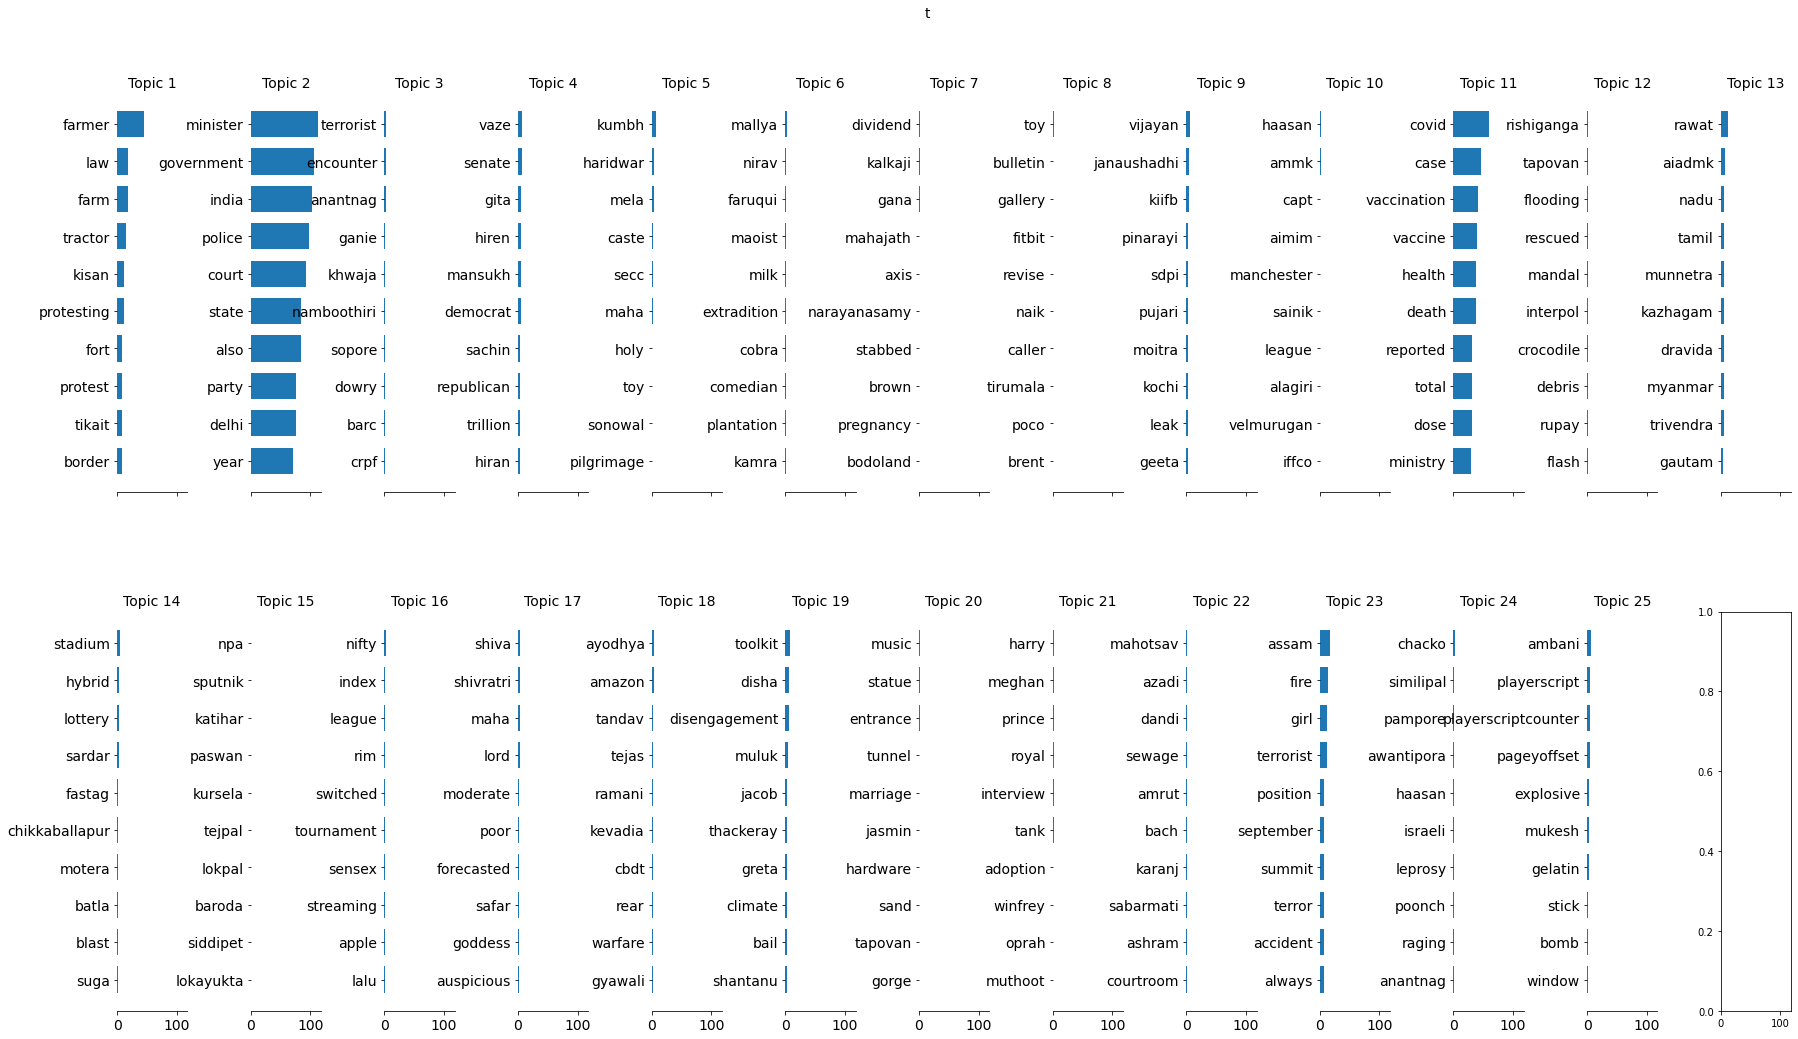

In [91]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 13, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=14)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, feature_names, 10, "t")

**Cosine Similarity of documents**

In [92]:
cos_sim = pd.DataFrame(cosine_similarity(topic_df.iloc[:, :-1]))
cos_sim

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4554,4555,4556,4557,4558,4559,4560,4561,4562,4563,4564,4565,4566,4567,4568,4569,4570,4571,4572,4573,4574,4575,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585,4586,4587,4588,4589,4590,4591,4592,4593
0,1.000000,0.486732,0.718245,0.704065,0.663559,0.304366,0.269875,0.259014,0.306069,0.433652,0.601885,0.059110,0.258575,0.114023,0.253991,0.037592,0.549774,0.271427,0.541326,0.440356,0.327507,0.639974,0.581517,0.456952,0.236073,0.349185,0.366176,0.662680,0.655241,0.748973,0.219691,0.169356,0.440801,0.136263,0.476601,0.263204,0.101301,0.422286,0.435898,0.552555,...,0.430822,0.473840,0.422260,0.147595,0.248284,0.668451,0.390303,0.468448,0.356752,0.401047,0.776536,0.418531,0.662302,0.289500,0.516291,0.431006,0.265099,0.529020,0.310774,0.406804,0.443026,0.142840,0.458167,0.431068,0.578788,0.342385,0.291192,0.354964,0.424665,0.448759,0.297444,0.222505,0.645626,0.193875,0.222746,0.440666,0.580925,0.397751,0.296867,0.156127
1,0.486732,1.000000,0.424404,0.675609,0.053727,0.126598,0.265780,0.305599,0.123991,0.525947,0.411073,0.034938,0.010441,0.092162,0.291231,0.107720,0.899213,0.768861,0.265477,-0.045623,0.180959,0.164541,0.154411,0.322938,0.184543,0.190798,0.117625,0.318522,0.187641,0.416356,0.157194,0.223974,0.126194,0.032671,0.443004,0.068651,0.149084,0.480287,0.188392,0.155156,...,0.512931,0.466964,0.418061,-0.044899,0.622469,0.705793,0.448138,0.305573,0.303628,0.673837,0.464739,0.577147,0.709863,0.543829,0.623274,0.227843,0.254280,0.535639,0.453793,0.492862,0.441702,0.047213,0.306140,0.399558,0.476521,0.542214,0.347541,0.586199,0.550123,0.503724,0.488889,0.174902,0.155543,0.175275,0.103608,0.079521,0.607626,0.196387,0.645519,0.092071
2,0.718245,0.424404,1.000000,0.643712,0.153647,0.300337,0.302026,0.346538,0.229282,0.294546,0.441216,0.074875,0.111280,0.232389,0.370341,0.084684,0.527685,0.232687,0.460148,0.163426,0.201267,0.562233,0.242289,0.396090,0.186498,0.272853,0.319996,0.465349,0.405366,0.709765,0.234795,0.198022,0.152704,0.174962,0.353632,0.195714,0.072648,0.238612,0.682465,0.149434,...,0.180222,0.461322,0.395765,-0.026862,0.105897,0.417766,0.276954,0.437836,0.265187,0.252618,0.746292,0.137118,0.716691,0.151397,0.351996,0.248962,0.308574,0.534872,0.085573,0.378970,0.209673,0.053070,0.500709,0.443315,0.170304,0.211565,0.073055,0.157828,0.233339,0.332680,0.150614,0.145583,0.469653,0.179968,0.218553,0.169623,0.258914,0.328930,0.191539,0.138954
3,0.704065,0.675609,0.643712,1.000000,0.277099,0.276223,0.236229,0.388490,0.517158,0.564007,0.583092,0.129927,-0.006369,0.197894,0.260525,0.094612,0.660207,0.390650,0.398503,0.105764,0.527195,0.352154,0.237439,0.502037,0.284594,0.435762,0.162361,0.357762,0.354928,0.548360,0.226262,0.173519,0.261291,0.206468,0.589516,0.204521,0.368074,0.404541,0.383817,0.291141,...,0.470896,0.437028,0.480536,0.042390,0.455389,0.726755,0.427808,0.587664,0.390469,0.419483,0.778485,0.400590,0.744797,0.486946,0.692351,0.368933,0.431793,0.676053,0.360318,0.635170,0.410607,0.220434,0.591302,0.591354,0.496319,0.613174,0.354782,0.502933,0.440742,0.496042,0.424240,0.499182,0.278703,0.363222,0.330191,0.146879,0.461546,0.330069,0.393459,0.016050
4,0.663559,0.053727,0.153647,0.277099,1.000000,0.451202,0.075897,0.208299,0.211087,0.089739,0.340653,0.059404,0.278624,0.107569,0.129117,0.134318,0.160157,0.052519,0.547056,0.497598,0.212703,0.344511,0.666238,0.274919,0.133458,0.249746,0.168979,0.556504,0.568524,0.349523,0.333827,0.215550,0.635514,0.301477,0.154617,0.520799,0.071359,0.201348,0.152037,0.705401,...,0.224070,0.334685,0.205798,0.026782,0.028171,0.498139,0.181809,0.223978,0.141915,0.248624,0.394211,0.234320,0.137874,0.038007,0.253536,0.461777,0.008289,0.069421,0.213362,0.080134,0.425422,0.041276,0.115783,0.228575,0.486028,0.135071,0.207033,0.098667,0.232739,0.163202,0.167010,0.090199,0.568579,0.095898,0.104243,0.556307,0.392251,0.463345,0.124876,0.191512
...,...,...,...,...,...,...,...,...,...,...,...,...

# **Creating Users and initial ratings**

**Generating Users**

In [93]:
#fitting GMM to column "topic_i"

num_cols_topic_df = topic_df.shape[1]-1
gm = []

for i in range(num_cols_topic_df):
  gm.append(GaussianMixture(n_components=10).fit(topic_df.iloc[:, [i]]))

In [94]:
#generating gmm based topic values for each topic for 50 users

Users = []

for i in range(50):
  temp = []
  for i in range(num_cols_topic_df):
    temp.append(gm[i].sample(1)[0][0][0])
  Users.append(temp)
Users=np.array(Users)
Users.T
l2norm = np.sqrt((Users * Users).sum(axis=1))
Users = pd.DataFrame(Users/l2norm.reshape(50,1))

In [95]:
#run the above cell before running this twice
slc = list(range(topic_df.shape[1]))
slc.remove(25)
temp_topic_df = topic_df.iloc[:, slc]
Users_temp = Users.T.set_index(temp_topic_df.T.index)

result = temp_topic_df.dot(Users_temp);

**Generating User ratings** 




In [96]:
rank_matrix = result.rank().T/4593*10
rank_matrix = rank_matrix.round(0).astype(int)
rank_matrix.columns =np.linspace(0,4593,4594).astype(int)
'''not every reader reads all news
so remove random elements from the rank matrix'''
for i in range(4594):
  random_entries = np.random.randint(0,50,25)
  rank_matrix.loc[random_entries,i] = "No rating"
rank_matrix = rank_matrix.apply(pd.to_numeric, errors='coerce')
rank_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4554,4555,4556,4557,4558,4559,4560,4561,4562,4563,4564,4565,4566,4567,4568,4569,4570,4571,4572,4573,4574,4575,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585,4586,4587,4588,4589,4590,4591,4592,4593
0,3.0,9.0,NaN,6.0,2.0,6.0,NaN,8.0,NaN,4.0,NaN,10.0,4.0,2.0,3.0,6.0,8.0,9.0,NaN,3.0,4.0,4.0,7.0,NaN,2.0,NaN,NaN,1.0,NaN,NaN,8.0,5.0,7.0,8.0,7.0,7.0,10.0,7.0,2.0,1.0,...,1.0,4.0,1.0,NaN,NaN,NaN,1.0,0.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,2.0,1.0,1.0,1.0,0.0,NaN,1.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,0.0,NaN,2.0,NaN,1.0,NaN,NaN,3.0,4.0
1,4.0,8.0,NaN,NaN,0.0,NaN,9.0,NaN,7.0,NaN,4.0,NaN,NaN,NaN,NaN,0.0,6.0,NaN,5.0,NaN,NaN,5.0,3.0,NaN,9.0,7.0,6.0,3.0,NaN,NaN,NaN,1.0,1.0,2.0,7.0,1.0,6.0,NaN,NaN,NaN,...,2.0,3.0,NaN,NaN,4.0,2.0,2.0,1.0,2.0,2.0,3.0,2.0,3.0,NaN,1.0,2.0,4.0,5.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,2.0,3.0,1.0,NaN,NaN,5.0,6.0,NaN,NaN,2.0,4.0,3.0
2,1.0,NaN,NaN,1.0,1.0,NaN,NaN,5.0,5.0,1.0,NaN,9.0,NaN,6.0,6.0,7.0,2.0,3.0,4.0,NaN,7.0,4.0,5.0,4.0,9.0,6.0,1.0,3.0,5.0,4.0,7.0,5.0,8.0,7.0,3.0,NaN,6.0,4.0,NaN,5.0,...,2.0,2.0,NaN,6.0,1.0,NaN,3.0,NaN,2.0,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN,3.0,3.0,4.0,NaN,3.0,NaN,1.0,3.0,NaN,NaN,2.0,NaN,3.0,NaN,6.0,7.0,NaN,1.0,5.0,NaN,NaN
3,3.0,1.0,NaN,6.0,NaN,9.0,8.0,7.0,7.0,NaN,NaN,6.0,1.0,6.0,NaN,NaN,NaN,4.0,NaN,1.0,9.0,7.0,NaN,3.0,NaN,NaN,1.0,NaN,5.0,3.0,10.0,NaN,8.0,NaN,NaN,10.0,NaN,5.0,7.0,5.0,...,2.0,6.0,4.0,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,2.0,5.0,1.0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,3.0,4.0,4.0,NaN,1.0,NaN,9.0,NaN,NaN
4,6.0,7.0,NaN,NaN,NaN,4.0,8.0,4.0,7.0,NaN,NaN,0.0,NaN,4.0,4.0,NaN,5.0,NaN,6.0,8.0,10.0,6.0,NaN,NaN,NaN,8.0,7.0,4.0,NaN,3.0,NaN,6.0,8.0,4.0,7.0,6.0,NaN,6.0,1.0,2.0,...,2.0,3.0,2.0,3.0,NaN,3.0,NaN,2.0,NaN,2.0,4.0,1.0,2.0,1.0,1.0,1.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN,3.0,NaN,3.0,2.0,NaN,3.0,2.0,2.0,NaN,NaN,3.0,1.0,5.0,NaN,5.0,4.0,3.0
5,6.0,NaN,9.0,NaN,8.0,NaN,0.0,6.0,1.0,NaN,NaN,NaN,3.0,6.0,NaN,9.0,3.0,NaN,5.0,8.0,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,7.0,NaN,10.0,7.0,NaN,9.0,NaN,10.0,NaN,NaN,7.0,6.0,...,NaN,NaN,1.0,3.0,2.0,3.0,1.0,2.0,NaN,NaN,4.0,1.0,2.0,1.0,1.0,NaN,3.0,5.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,2.0,NaN,1.0,NaN,1.0,NaN,NaN,4.0,9.0,2.0,0.0
6,7.0,9.0,NaN,9.0,6.0,5.0,1.0,3.0,NaN,6.0,5.0,NaN,NaN,1.0,2.0,0.0,NaN,NaN,3.0,2.0,10.0,8.0,NaN,NaN,NaN,NaN,NaN,3.0,6.0,5.0,NaN,1.0,7.0,NaN,NaN,NaN,9.0,6.0,NaN,NaN,...,NaN,NaN,2.0,5.0,NaN,4.0,NaN,2.0,1.0,2.0,NaN,3.0,3.0,2.0,2.0,4.0,NaN,NaN,3.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,5.0,NaN,1.0
7,2.0,NaN,4.0,NaN,1.0,NaN,0.0,5.0,3.0,1.0,NaN,7.0,NaN,7.0,NaN,NaN,NaN,4.0,3.0,5.0,NaN,6.0,NaN,NaN,NaN,6.0,4.0,1.0,NaN,NaN,9.0,NaN,9.0,NaN,5.0,NaN,NaN,5.0,NaN,NaN,...,NaN,4.0,NaN,5.0,NaN,NaN,NaN,1.0,2.0,1.0,2.0,1.0,2.0,NaN,1.0,2.0,4.0,3.0,2.0,2.0,2.0,5.0,1.0,2.0,1.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,0.0
8,7.0,9.0,9.0,NaN,7.0,2.0,NaN,2.0,NaN,9.0,4.0,NaN,2.0,NaN,2.0,5.0,6.0,9.0,NaN,4.0,NaN,NaN,NaN,NaN,9.0,4.0,4.0,NaN,7.0,NaN,2.0,6.0,NaN,NaN,5.0,3.0,NaN,NaN,4.0,8.0,...,2.0,1.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,3.0,4.0,NaN,4.0,NaN,NaN,2.0,2.0,5.0,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0,3.0,2.0,1.0,1.0
9,4.0,9.0,7.0,8.0,3.0,3.0,8.0,3.0,NaN,4.0,4.0,8.0,1.0,1.0,NaN,8.0,8.0,9.0,4.0,NaN,NaN,8.0,NaN,3.0,NaN,8.0,NaN,NaN,NaN,3.0,5.0,NaN,7.0,NaN,NaN,NaN,8.0,5.0,2.0,4.0,...,NaN,NaN,1.0,NaN,NaN,1.0,0.0,0.0,1.0,0.0,1.0,NaN,1.0,NaN,0.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN,5.0,6.0


# **Content based recommender function**

In [97]:
def content_recommender(rank_matrix,cos_sim):
  
  #find top 5 ratings
  top_five = rank_matrix.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=5)

  #best two similar docs for every doc
  best_two = cos_sim.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=3)
  best_two.columns =['0', '1','2']
  del best_two['0']
  best_two['combined']= best_two.values.tolist()
  best_two
  best_two_dict_1 = best_two['1'].to_dict()
  best_two_dict_2 = best_two['2'].to_dict()

  selected_docs_1 = top_five.replace(best_two_dict_1)
  selected_docs_2 = top_five.replace(best_two_dict_2)
  selected_docs_with_ID = pd.concat([selected_docs_1,selected_docs_2],axis=1,ignore_index=True)

  #replace value by the actual news
  doc_dict = news_corpus_org.Content.to_dict()

  selected_docs = selected_docs_with_ID.replace(doc_dict)
  return selected_docs, selected_docs_with_ID

# **Top 10 news : Content based recommender.**

In [98]:
selected_docs_content,selected_docs_content_with_ID = content_recommender(rank_matrix,cos_sim)
selected_docs_content

,0,1,2,3,4,5,6,7,8,9
0,Daily COVID-19 cases in India registered an i...,"Udhampur (Jammu and Kashmir) [India], March 8...","The first ‘Quadrilateral Security Dialogue’, ...","Amaravati (Andhra Pradesh) [India], February ...",The British parliament on Monday discussed fa...,New cases of coronavirus infection in India w...,Prime Minister Narendra Modi on Tuesday gave a...,External Affairs Minister S Jaishankar will on...,"Shillong (Meghalaya) [India], February 25 (AN...",The Indian High Commission in London has cond...
1,Congress leader Rahul Gandhi on Sunday compar...,With several States in the country continuing ...,Farmers are ready to stay put on Delhi borders...,"New Delhi [India], February 25 (ANI): With 3,...",With several States in the country continuing ...,"Meerut (Uttar Pradesh) [India], March 7 (ANI)...","Maharashtra, Kerala, Punjab, Tamil Nadu, Gujar...","Shivamogga (Karnataka) [India], February 25 (...","New Delhi [India], March 7 (ANI): The cumulat...","New Delhi [India], March 6 (ANI): Maharashtra..."
2,Women are likely to play a major role in ensur...,The second round of meeting between the polic...,Farmer leader Rakesh Tikait on Monday took a d...,Around 600 farmers from Rajasthan tried to bre...,Congress leader Rahul Gandhi on Sunday compar...,NEW DELHI (Reuters) - Thousands of women join...,Agitating farmer union on February 23 objected...,More than 850 faculty members of various educa...,The Republic Day tractor parade by agitating f...,Urging the Centre not to make the agri laws a ...
3,The Supreme Court on Friday asked the governme...,While hearing a plea filed by NCP leader Ekna...,Petrol prices on Tuesday neared the ₹91 per l...,"By Siddharth SharmaNew Delhi [India], March 2...","New Delhi [India], March 4 (ANI): The Delimit...",A Constitution Bench of the Supreme Court on T...,The CBI has taken over a probe into 26 identic...,"By Shailesh YadavNew Delhi [India], March 2 (...","New Delhi [India], March 2 (ANI): The Bharati...","Jammu (Jammu and Kashmir) [India], February 2..."
4,"By Siddharth SharmaNew Delhi [India], March 7...","New Delhi [India], March 10 (ANI): The nation...","New Delhi [India], March 10 (ANI): The nation...","Pune (Maharashtra) [India], March 5 (ANI): Un...","New Delhi [India], March 1 (ANI): The Indian ...",A face-off between two political rivals — the ...,"New Delhi [India], March 9 (ANI): The nationw...",Nearly 17 lakh COVID vaccine doses were admini...,"New Delhi [India], March 8 (ANI): The cumulat...","Thiruvananthapuram (Kerala) [India], March 3 ..."
5,The Supreme Court on Friday asked the governme...,While hearing a plea filed by NCP leader Ekna...,The Interpol has issued a red notice to locate...,The Supreme Court judges have informally told ...,"Kochi (Kerala) [India], March 4 (ANI): Kerala...",A Constitution Bench of the Supreme Court on T...,The CBI has taken over a probe into 26 identic...,The Union home ministry on Monday said ₹ 200 ...,"New Delhi [India], March 9 (ANI): The Supreme...","Kochi (Kerala) [India], March 9 (ANI): The s..."
6,"By Siddharth SharmaNew Delhi [India], March 7...",As suspense looms over the fate of the leader...,Tirath Singh Rawat has been sworn in as the ne...,Former Congress president Rahul Gandhi on Tues...,New cases of coronavirus infection in India w...,A face-off between two political rivals — the ...,"Dehradun (Uttarakhand) [India], March 9 (ANI)...","Dehradun (Uttarakhand) [India], March 9 (ANI)...","Mumbai (Maharashtra) [India], March 3 (ANI): ...",The daily new coronavirus (COVID-19) cases fe...
7,"Amaravati (Andhra Pradesh) [India], March 8 (...",Congress leader Rahul Gandhi on Sunday compar...,"New Delhi [India], March 9 (ANI): On the occa...",Farmer leader Rakesh Tikait on Monday took a d...,Congress leader Rahul Gandhi on Sunday compar...,The task force set up to take a re-look at the...,"Meerut (Uttar Pradesh) [India], March 7 (ANI)...",Varanasi (Uttar Pradesh) [India] March 9 (ANI...,More than 850 faculty members of various educa..

# **Collaborative recommender function: Predict missing ratings using Matrix factorization**

In [99]:
#collaborative recommender function

def collaborative_recommender(rank_matrix,num_iter,news_corpus):
  A = np.array(rank_matrix)
  M = A.shape[0]
  N = A.shape[1]
  A_df = pd.DataFrame(A)
  K = 25
  W = np.abs(np.random.uniform(low=0, high=1, size=(M, K)))
  H = np.abs(np.random.uniform(low=0, high=1, size=(K, N)))
  W = np.divide(W, K*W.max())
  H = np.divide(H, K*H.max())

  #cost func
  def cost(A, W, H):
    mask = pd.DataFrame(A).notnull().values
    WH = np.dot(W, H)
    WH_mask = WH[mask]
    A_mask = A[mask]
    A_WH_mask = A_mask-WH_mask
    return linalg.norm(A_WH_mask, 2)
  
  #optimization loop
  num_display_cost = max(int(num_iter/10), 1)

  for i in range(num_iter):
      if i%2 ==0:
          # Learn H, given A and W
          for j in range(N):
              mask_rows = pd.Series(A[:,j]).notnull()
              H[:,j] = nnls(W[mask_rows], A[:,j][mask_rows])[0]
      else:
          for j in range(M):
              mask_rows = pd.Series(A[j,:]).notnull()
              W[j,:] = nnls(H.transpose()[mask_rows], A[j,:][mask_rows])[0]
              
      WH = np.dot(W, H)
      c = cost(A, W, H)
      #if i%num_display_cost==0:
      print(i, c)
  W = pd.DataFrame(W)
  H = pd.DataFrame(H)
  A = W.dot(H)
  
  #new rank matrix
  A = A.round(0).astype(int)
  A = np.clip(A,1,10)
  #finding the top 10 documents
  selected_docs_with_ID = A.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=10)
  selected_docs_with_ID.columns =['1', '2', '3', '4', '5','6','7','8','9','10']
  doc_dict = news_corpus_org.Content.to_dict()
  selected_docs = selected_docs_with_ID.replace(doc_dict)
  return selected_docs, selected_docs_with_ID

# **Top 10 news : Collaborative recommender.**

In [100]:
num_iter = 10
selected_docs_collab,selected_docs_collab_with_ID = collaborative_recommender(rank_matrix,num_iter,news_corpus)
selected_docs_collab

0 779.7494411013222
1 642.3304595633984
2 531.1334483358476
3 465.30199195205756
4 423.5652625130765
5 395.74071085865205
6 375.557906637953
7 360.2258421774542
8 348.54274962883295
9 339.2252922297836


,1,2,3,4,5,6,7,8,9,10
0,India recorded its highest daily tally of COV...,Senior Congress leader Saifuddin Soz on Tuesd...,Prime Minister Narendra Modi on Tuesday virtua...,The High Commission of India in London has con...,A court in Delhi on March 8 convicted Ariz Kha...,The Centre on Friday set up a high-level commi...,Prime Minister Narendra Modi on Friday said p...,The Delhi High Court March 4 asked the Centre...,"The Delimitation Commission, a panel for redra...",Health Minister Harsh Vardhan on Wednesday rei...
1,The first ever summit of the leaders of the Qu...,Congress General Secretary Priyanka Gandhi Vad...,As the farmers’ agitation over the new farm la...,A week after the show of strength in Jammu by ...,The British Parliament will discuss the three ...,Health Minister Harsh Vardhan on Wednesday rei...,President Ram Nath Kovind on Tuesday was admin...,The cumulative number of COVID-19 vaccine dose...,The cumulative number of COVID-19 vaccine dose...,The Union Health Ministry will soon issue the ...
2,The Health Ministry on Tuesday informed the El...,The cumulative number of COVID-19 vaccine dose...,Nearly 17 lakh COVID vaccine doses were admini...,Congress General Secretary Priyanka Gandhi Vad...,Continuing with his attack on the BJP governm...,A 49-year-old farmer from Haryana’s Hisar dist...,Agriculture Minister Narendra Singh Tomar on S...,More than 20 million vaccine doses have been a...,"Hundreds of farmers, including women, held a b...",As the farmers’ agitation over the new farm la...
3,A petition has been filed in the Supreme Court...,The Supreme Court on Wednesday asked the gover...,The CBI informed the Supreme Court on Wednesda...,A Constitution Bench led by Chief Justice of I...,The Delhi High Court on Wednesday gave an int...,The Supreme Court said on March 10 it would h...,"An NGO, Association for Democratic Reforms, re...",The Supreme Court's initiative to begin hybrid...,A week after the show of strength in Jammu by ...,The Andhra Pradesh government orally stated in...
4,After severe criticism over not holding consul...,The Congress had always stood for internal dis...,"For the third day in a row, both Houses of Par...",On International Women’s Day which was celebra...,Multiple adjournment motions marred the workin...,Nearly 17 lakh COVID vaccine doses were admini...,Thousands of women farmers held protest marche...,Rajya Sabha Chairman M. Venkaiah Naidu on Mar...,"BJP leader Jyotiraditya Scindia, who quit the ...",The cumulative doses of COVID19 vaccine admini...
5,A petition has been filed in the Supreme Court...,A Constitution Bench led by Chief Justice of I...,The Supreme Court said on March 10 it would h...,The Enforcement Directorate has arrested two p...,Investigation in only 32% cases of sexual offe...,The Union home ministry on Monday said ₹ 200 ...,A court in Delhi on March 8 convicted Ariz Kha...,About 700 entities which had taken the assista...,The COVID-19 pandemic has negatively affected ...,New cases of coronavirus infection in India w...
6,Former Congress president Rahul Gandhi on Thur...,The Congress had always stood for internal dis...,Prime Minister Narendra Modi will flag off the...,The Congress on Tuesday said the President of ...,The crisis over the continuation of Uttarakhan...,"BJP leader Jyotiraditya Scindia, who quit the ...",All households in Gujarat will get tap water ...,Breaking her silence on the IT department raid...,The Congress is changing the way it selects ca...,The Centre on Friday set up a high-level commi...
7,The Supreme Court on Wednesday asked the gover...,Multiple adjournment motions marred the workin...,The Union home ministry on Monday said ₹ 200 ...,Congress General Secretary Priyanka Gandhi Vad...,Agriculture Minister Narendra Singh Tomar on S...,As the farmers’ agitation over the new farm la...,An independent research commissioned by Twitte...,As the farmers protest completed 100 days on t...,The Andhra Pradesh government orally stated in...,The Delhi Hig

# **Hydrid recommender**

In [101]:
def hybrid(collaborative_recommender,content_recommender,rank_matrix,cos_sim,news_corpus):
  selected_docs_collab,selected_docs_collab_with_ID = collaborative_recommender(rank_matrix,num_iter,news_corpus)
  selected_docs_content,selected_docs_content_with_ID = content_recommender(rank_matrix,cos_sim)
  
  selected_docs_collab.reset_index(drop=True, inplace=True)
  selected_docs_content.reset_index(drop=True, inplace=True)
  
  selected_docs_collab_with_ID.reset_index(drop=True, inplace=True)
  selected_docs_content_with_ID.reset_index(drop=True, inplace=True)
  
  selected_docs_final = pd.concat([selected_docs_content.iloc[:,[0,1,2,3,4]],selected_docs_collab.iloc[:,[5,6,7,8,9]]],axis=1)
  selected_docs_final_with_ID = pd.concat([selected_docs_content_with_ID.iloc[:,[0,1,2,3,4]],selected_docs_collab_with_ID.iloc[:,[5,6,7,8,9]]],axis=1)
  
  return selected_docs_final,selected_docs_final_with_ID

# **Top 10 news : Hybrid recommender.**

In [102]:
selected_docs_final,selected_docs_final_with_ID = hybrid(collaborative_recommender,content_recommender,rank_matrix,cos_sim,news_corpus)
selected_docs_final

0 776.860178675389
1 643.5376642956235
2 532.5219923744752
3 465.56544374858765
4 423.4421288183655
5 397.6318774979287
6 378.51055017225383
7 363.6956847240484
8 352.22667198260115
9 344.007057826016


,0,1,2,3,4,6,7,8,9,10
0,Daily COVID-19 cases in India registered an i...,"Udhampur (Jammu and Kashmir) [India], March 8...","The first ‘Quadrilateral Security Dialogue’, ...","Amaravati (Andhra Pradesh) [India], February ...",The British parliament on Monday discussed fa...,Nearly 17 lakh COVID vaccine doses were admini...,Prime Minister Narendra Modi on March 7 said t...,Conveying his strong appreciation for the “res...,More than 20 million vaccine doses have been a...,The cumulative doses of COVID19 vaccine admini...
1,Congress leader Rahul Gandhi on Sunday compar...,With several States in the country continuing ...,Farmers are ready to stay put on Delhi borders...,"New Delhi [India], February 25 (ANI): With 3,...",With several States in the country continuing ...,New cases of coronavirus infection in India w...,The Centre on Friday set up a high-level commi...,A week after the show of strength in Jammu by ...,"Maharashtra, Kerala, Punjab, Tamil Nadu, Gujar...",Health Minister Harsh Vardhan on Wednesday rei...
2,Women are likely to play a major role in ensur...,The second round of meeting between the polic...,Farmer leader Rakesh Tikait on Monday took a d...,Around 600 farmers from Rajasthan tried to bre...,Congress leader Rahul Gandhi on Sunday compar...,Union Health Secretary Rajesh Bhushan said on ...,Agitating farmer union on February 23 objected...,Farmer leader Rakesh Tikait on Monday took a d...,Asserting that they won’t return home till the...,"India is third globally, after the U.S. and t..."
3,The Supreme Court on Friday asked the governme...,While hearing a plea filed by NCP leader Ekna...,Petrol prices on Tuesday neared the ₹91 per l...,"By Siddharth SharmaNew Delhi [India], March 2...","New Delhi [India], March 4 (ANI): The Delimit...",The Election Commission (EC) on Tuesday issued...,"Price of domestic cooking gas, LPG has double...",The government has said the amendments introdu...,A court in Delhi on March 8 convicted Ariz Kha...,The crisis over the continuation of Uttarakhan...
4,"By Siddharth SharmaNew Delhi [India], March 7...","New Delhi [India], March 10 (ANI): The nation...","New Delhi [India], March 10 (ANI): The nation...","Pune (Maharashtra) [India], March 5 (ANI): Un...","New Delhi [India], March 1 (ANI): The Indian ...",Thousands of women farmers held protest marche...,Rajya Sabha Chairman M. Venkaiah Naidu on Mar...,"BJP leader Jyotiraditya Scindia, who quit the ...",Congress General Secretary Priyanka Gandhi Vad...,The cumulative doses of COVID19 vaccine admini...
5,The Supreme Court on Friday asked the governme...,While hearing a plea filed by NCP leader Ekna...,The Interpol has issued a red notice to locate...,The Supreme Court judges have informally told ...,"Kochi (Kerala) [India], March 4 (ANI): Kerala...",Investigation in only 32% cases of sexual offe...,The Union home ministry on Monday said ₹ 200 ...,The finance ministry on Monday said about 55 %...,A court in Delhi on March 8 convicted Ariz Kha...,Saluting women healthcare workers on Internat...
6,"By Siddharth SharmaNew Delhi [India], March 7...",As suspense looms over the fate of the leader...,Tirath Singh Rawat has been sworn in as the ne...,Former Congress president Rahul Gandhi on Tues...,New cases of coronavirus infection in India w...,The Congress on Tuesday said the President of ...,The crisis over the continuation of Uttarakhan...,"BJP leader Jyotiraditya Scindia, who quit the ...",The COVID-19 pandemic has negatively affected ...,Days after the Sri Lankan cabinet decided to a...
7,"Amaravati (Andhra Pradesh) [India], March 8 (...",Congress leader Rahul Gandhi on Sunday compar...,"New Delhi [India], March 9 (ANI): On the occa...",Farmer leader Rakesh Tikait on Monday took a d...,Congress leader Rahul Gandhi on Sunday compar...,The High Commission of India in London has con...,On International Women’s Day which was celebra...,Thousands of women farmers held protest marche...,Noted classical dancer and nominated Rajya Sab...,The U

# **User Profile Updater**

Implemented in the flask app. See the attached app.py file.